In [1]:
import sys

sys.path.append("/Users/kanishkjain/opt/anaconda3/envs/gym/lib/python3.9/site-packages")

import random
import collections
from pprint import pprint

import gym
import gym_toytext
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter1d

In [3]:
class Agent:
    def __init__(
        self, environment="Taxi-v3"
    ) -> None:

        self.environment = environment

    def epsilon_greedy_policy(self, Pi, epsilon):

        p = np.random.rand()
        Num_A = len(Pi)
        if p < epsilon:
            return np.random.choice(Num_A)
        else:
            # pi_max = np.where(np.max(Pi)==Pi)[0]
            # A = np.random.choice(pi_max)
            a_star = np.max(Pi)
            max_indices = [i for i in range(Num_A) if Pi[i]==a_star]
            A = np.random.choice(max_indices)
            return A

    def q_learning(self, num_iter=10000, alpha=0.1, gamma=0.9, epsilon = 0.05):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):

            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")

            S = env.reset()
            
            G = 0
            step = 0
            while True:
                A = self.epsilon_greedy_policy(Q[S], epsilon)
                S_, R, terminal, _ = env.step(A)
                
                G = G + (gamma**step)*R

                Q[S][A] += alpha * (R + gamma * np.max(Q[S_]) - Q[S][A])

                S = S_
                
                step+=1

                if terminal:
                    break
                    
            rewards[it -1] = G
            # env.close()

        return Q, rewards

    def double_q_learning(self, num_iter=10000, alpha=0.1, gamma=0.9, epsilon = 0.05):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q1 = np.zeros((Num_S, Num_A))
        Q2 = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):

            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")
            
            S = env.reset()
            
            G = 0
            step = 0
            while True:
                
                A = self.epsilon_greedy_policy(Q1[S]+Q2[S], epsilon)

                S_, R, terminal, _ = env.step(A)
                
                G = G + (gamma**step)*R

                p = np.random.rand()

                if p < 0.5:
                    Q1[S, A] += alpha * (R + gamma * Q2[S_, np.argmax(Q1[S_])] - Q1[S, A])
                else:
                    Q2[S, A] += alpha * (R + gamma * Q1[S_, np.argmax(Q2[S_])] - Q2[S, A])

                S = S_
                
                step += 1
                if terminal:
                    break
            rewards[it -1] = G
            # env.close()
        return Q1, Q2, rewards

    def sarsa(self, num_iter=10000, alpha=0.1, gamma=0.9, epsilon = 0.05):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):
            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")

            S = env.reset()
            A = self.epsilon_greedy_policy(Q[S], epsilon)
            
            G = 0
            step = 0
            while True:
                S_, R, terminal, _ = env.step(A)
                A_ = self.epsilon_greedy_policy(Q[S_], epsilon)
                
                G = G + (gamma**step)*R

                Q[S][A] = Q[S][A] + alpha * (R + gamma * Q[S_][A_] - Q[S][A])

                S = S_
                A = A_
                
                step += 1

                if terminal:
                    break
            rewards[it -1] = G
            # env.close()

        return Q, rewards

    def expected_sarsa(self, num_iter=10000, alpha=0.1, gamma=0.9, epsilon = 0.05):
        
        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):
            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")

            S = env.reset()
            A = self.epsilon_greedy_policy(Q[S], epsilon)

            G = 0
            step = 0
            while True:
                S_, R, terminal, _ = env.step(A)
                A_ = self.epsilon_greedy_policy(Q[S_], epsilon)
                
                G = G + (gamma**step)*R

                # q_star = np.max(Q[S_])
                # greedy_actions = 0
                # for a in range(Num_A):
                #     if Q[S_][a] == q_star:
                #         greedy_actions += 1

                # expected_sum = 0
                # for a in range(Num_A):
                #     if Q[S_][a] == q_star:
                #         expected_sum += (
                #             ((1 - epsilon) / greedy_actions)
                #             + epsilon / Num_A
                #         ) * Q[S_][a]
                #     else:
                #         expected_sum += (epsilon / Num_A) * Q[S_][a]
                
                max_indices = np.where(np.max(Q[S_]) == Q[S_])[0]
                other_indices = np.where(np.max(Q[S_]) != Q[S_])[0]

                pi = np.zeros(Num_A)
                pi[max_indices] = (1 - epsilon)/len(max_indices) + epsilon/Num_A
                pi[other_indices] = epsilon / Num_A

                expected_sum = sum(pi*Q[S_])

                Q[S][A] += alpha * (R + (gamma * expected_sum) - Q[S][A])

                S = S_
                A = A_
                
                step += 1
                
                if terminal:
                    break
            rewards[it -1] = G
            
        return Q, rewards

    def show_policy(self, Q):

        MAX_STEPS = 51
        
        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n

        S = env.reset()
        print(f"Starting state: {S}")

        step = 0
        done = False
        while step < MAX_STEPS:
            A = np.argmax(Q[S])
            env.render()
            S_, R, done, _ = env.step(A)
            if done:
                break
            print(
                f"Current State: {S}, action: {A}, reward: {R}, terminal: {done}, step: {step}"
            )
            S = S_
            step += 1
        if done:
            print(
                f"Current State: {S}, action: {A}, reward: {R}, terminal: {done}, step: {step}"
            )
            env.render()
        env.close()
        print("Finished", done)

In [4]:
agent = Agent(environment='Taxi-v3')

In [5]:
Q_q, R_q = agent.q_learning()
agent.show_policy(Q_q)
R_q = gaussian_filter1d(R_q, sigma=50)

Generating Episode Number: 5000
Generating Episode Number: 10000
Starting state: 448
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Current State: 448, action: 1, reward: -1, terminal: False, step: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Current State: 348, action: 1, reward: -1, terminal: False, step: 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Current State: 248, action: 3, reward: -1, terminal: False, step: 2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 228, action: 3, reward: -1, terminal: False, step: 3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 208, action: 0, reward: -1, terminal: False, step: 4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 308, ac

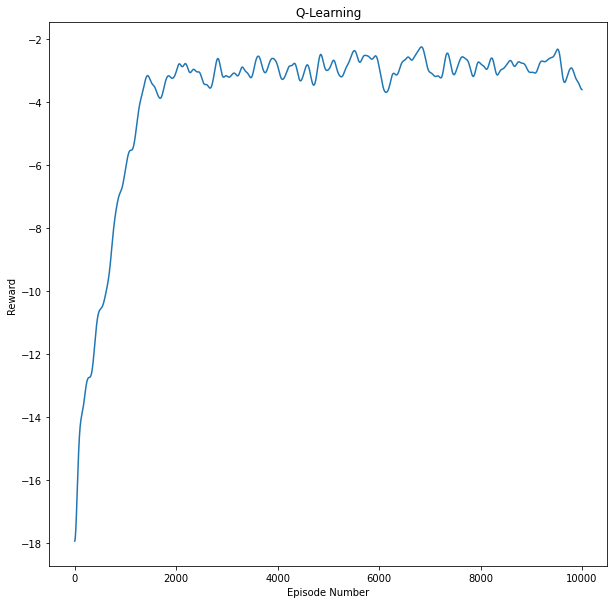

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.plot(R_q)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('Q-Learning')
plt.show()

In [7]:
Q1_2q, Q2_2q, R_2q = agent.double_q_learning()
R_2q = gaussian_filter1d(R_2q, sigma=50)

Generating Episode Number: 5000
Generating Episode Number: 10000


In [8]:
print("======== Policy 1 ========")
agent.show_policy(Q1_2q)

======== Policy 1 ========
Starting state: 123
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Current State: 123, action: 3, reward: -1, terminal: False, step: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 103, action: 1, reward: -1, terminal: False, step: 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Current State: 3, action: 4, reward: -1, terminal: False, step: 2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Current State: 19, action: 0, reward: -1, terminal: False, step: 3
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 119, action: 0, reward: -1, terminal: False, step: 4
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 219, action: 2, reward: -1, terminal: False, s

In [9]:
print("======== Policy 2 ========")
agent.show_policy(Q2_2q)

======== Policy 2 ========
Starting state: 349
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Current State: 349, action: 3, reward: -1, terminal: False, step: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 329, action: 1, reward: -1, terminal: False, step: 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Current State: 229, action: 3, reward: -1, terminal: False, step: 2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 209, action: 0, reward: -1, terminal: False, step: 3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 309, action: 0, reward: -1, terminal: False, step: 4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 409, action: 4, reward: -1, terminal: False, 

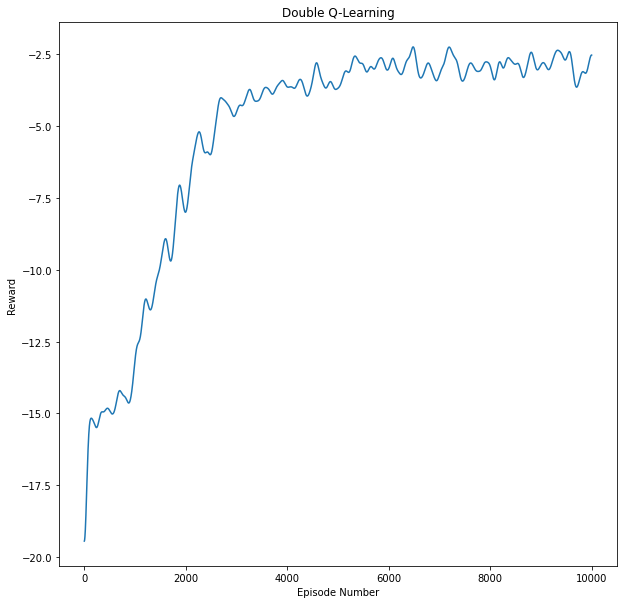

In [10]:
fig = plt.figure(figsize=(10, 10))
plt.plot(R_2q)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('Double Q-Learning')
plt.show()

In [11]:
Q_sarsa, R_sarsa = agent.sarsa()
agent.show_policy(Q_sarsa)
R_sarsa = gaussian_filter1d(R_sarsa, sigma=30)

Generating Episode Number: 5000
Generating Episode Number: 10000
Starting state: 472
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Current State: 472, action: 4, reward: -1, terminal: False, step: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Current State: 476, action: 1, reward: -1, terminal: False, step: 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
Current State: 376, action: 1, reward: -1, terminal: False, step: 2
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Current State: 276, action: 3, reward: -1, terminal: False, step: 3
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 256, action: 3, reward: -1, terminal: False, step: 4
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 236, a

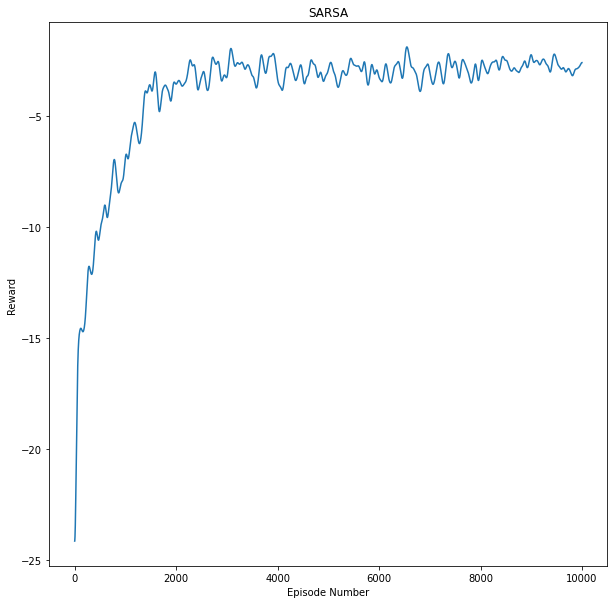

In [12]:
fig = plt.figure(figsize=(10, 10))
plt.plot(R_sarsa)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('SARSA')
plt.show()

In [13]:
Q_exp_sarsa, R_exp_sarsa = agent.expected_sarsa()
agent.show_policy(Q_exp_sarsa)
R_exp_sarsa = gaussian_filter1d(R_exp_sarsa, sigma=50)

Generating Episode Number: 5000
Generating Episode Number: 10000
Starting state: 122
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Current State: 122, action: 3, reward: -1, terminal: False, step: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Current State: 102, action: 1, reward: -1, terminal: False, step: 1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Current State: 2, action: 4, reward: -1, terminal: False, step: 2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Current State: 18, action: 0, reward: -1, terminal: False, step: 3
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 118, action: 0, reward: -1, terminal: False, step: 4
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Current State: 218, act

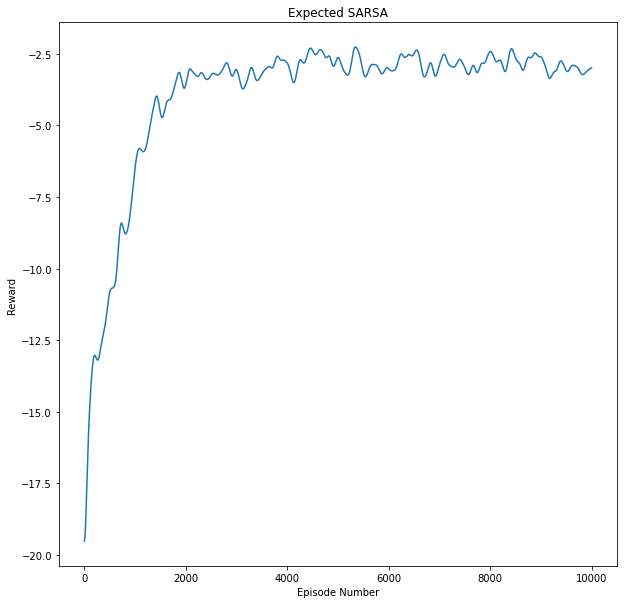

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.plot(R_exp_sarsa)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('Expected SARSA')
plt.show()

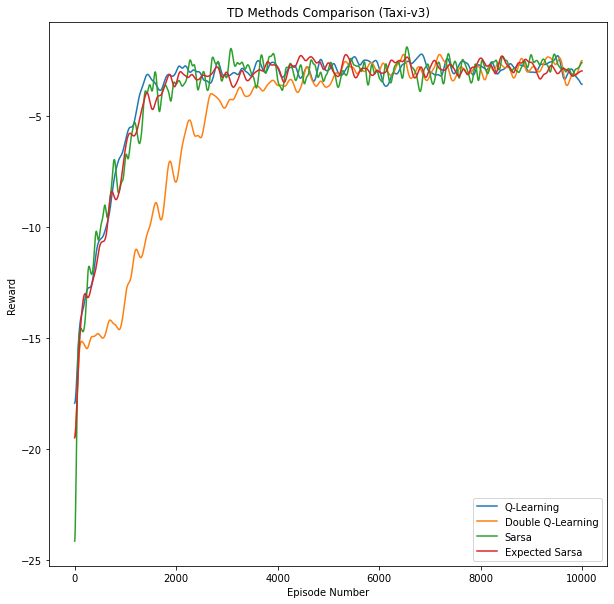

In [15]:
fig = plt.figure(figsize=(10, 10))

plt.plot(R_q, label="Q-Learning")
plt.plot(R_2q, label="Double Q-Learning")
plt.plot(R_sarsa, label="Sarsa")
plt.plot(R_exp_sarsa, label="Expected Sarsa")

plt.legend()
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('TD Methods Comparison (Taxi-v3)')
plt.show()